# Making a movie of voltage activity

We'll create a simple network made up of one imported morphology.

First we need to download the morphology.

In [4]:
import urllib.request

urllib.request.urlretrieve(
    "https://raw.githubusercontent.com/Neurosim-lab/netpyne/development/doc/source/code/BS0284.swc",
    "BS0284.swc",
)

('BS0284.swc', <http.client.HTTPMessage at 0x7ce6fafad510>)

Then we need to import the morphology.

In [5]:
from netpyne import specs, sim
%matplotlib inline

netParams = specs.NetParams()

cellRule = netParams.importCellParams(
    label='swc_cell', 
    fileName='BS0284.swc', 
    cellName='BS0284',
    )

For convenience, we'll rename the first soma section in the morphology from `soma_0` to `soma`.

In [6]:
netParams.renameCellParamsSec("swc_cell", "soma_0", "soma")

Next we'll add Hodgkin-Huxley mechanisms to the soma and a passive leak mechanism everywhere else.

In [7]:
for secName in cellRule["secs"]:
    cellRule["secs"][secName]["geom"]["cm"] = 1
    if secName.startswith("soma"):
        cellRule["secs"][secName]["mechs"]["hh"] = {
            "gnabar": 0.12,
            "gkbar": 0.036,
            "gl": 0.003,
            "el": -70,
        }
    else:
        cellRule["secs"][secName]["mechs"]["pas"] = {
            "g": 0.0000357,
            "e": -70,
        }

Now we'll make a population out of our imported cell.

In [8]:
netParams.popParams["swc_pop"] = {"cellType": "swc_cell", "numCells": 1}

Now we'll add a stimulation into the soma to cause an action potential.

In [9]:
netParams.synMechParams["exc"] = {
    "mod": "Exp2Syn",
    "tau1": 0.1,
    "tau2": 5.0,
    "e": 0,
}

netParams.stimSourceParams["bkg"] = {
    "type": "NetStim",
    "rate": 10,
    "noise": 0.0,
}

netParams.stimTargetParams["bkg->swc_cell"] = {
    "source": "bkg",
    "conds": {"cellType": "swc_cell"},
    "weight": 0.1,
    "delay": 10,
    "synMech": "exc",
}

Then we'll set up the simulation configuration.

In [10]:
cfg = specs.SimConfig()
cfg.filename = "plotshape"
cfg.duration = 30
cfg.recordTraces = {"V_soma": {"sec": "soma", "loc": 0.5, "var": "v"}}
cfg.recordStep = 0.5
cfg.analysis["plotTraces"] = {"include": ["all"], "showFig": True}

At this point, we could complete everything with `sim.createSimulateAnalyze(netParams=netParams, simConfig=cfg)`, but we want to plot a movie frame at a certain interval, so we need to execute the simulation commands individually.

In [11]:
sim.initialize(simConfig=cfg, netParams=netParams)
sim.net.createPops()
sim.net.createCells()
sim.net.connectCells()
sim.net.addStims()
sim.setupRecording()


Start time:  2024-10-30 15:37:00.398923




Creating network of 1 cell populations on 1 hosts...: 100%|##########|

  Number of cells on node 0: 1 
  Done; cell creation time = 0.03 s.
Making connections...
  Number of connections on node 0: 0 
  Done; cell connection time = 0.00 s.
Adding stims...
  Number of stims on node 0: 1 
  Done; cell stims creation time = 0.00 s.
Recording 1 traces of 1 types on node 0


{spkt: Vector[0], spkid: Vector[1], V_soma: {cell_0: Vector[2]}, t: Vector[3], _repr_mimebundle_: {}}

At this point, we could run the simulation with `sim.runSim()`, but we want to execute the following at intervals:
    
    sim.analysis.plotShape(
        includePre  = [0], 
        includePost = [0], 
        cvar        = 'voltage', 
        clim        = [-70, -20], 
        saveFig     = 'movie', 
        showFig     = False,
    )
    
First we have to make a dictionary of the arguments we want to feed into plotShape:

In [12]:
plotArgs = {
    "includePre": [0],
    "includePost": [0],
    "cvar": "voltage",
    "clim": [-70, -20],
    "saveFig": "movie",
    "showFig": False,
}

Then we can replace `sim.runSim()` with:

In [13]:
sim.runSimWithIntervalFunc(
    1.0, sim.analysis.plotShape, timeRange=[10, 20], funcArgs=plotArgs
)


Running with interval func using NEURON for 30.0 ms...
Plotting 3D cell shape ...

There was an exception in plotShape()
Plotting 3D cell shape ...

There was an exception in plotShape()
Plotting 3D cell shape ...

There was an exception in plotShape()
Plotting 3D cell shape ...

There was an exception in plotShape()
Plotting 3D cell shape ...

There was an exception in plotShape()
Plotting 3D cell shape ...

There was an exception in plotShape()
Plotting 3D cell shape ...

There was an exception in plotShape()
Plotting 3D cell shape ...

There was an exception in plotShape()
Plotting 3D cell shape ...

There was an exception in plotShape()
Plotting 3D cell shape ...

There was an exception in plotShape()
  Done; run time = 0.02 s; real-time ratio: 1.23.


Traceback (most recent call last):
  File "/home/hyunsu/miniconda3/envs/netpyne/lib/python3.10/site-packages/netpyne/analysis/utils.py", line 75, in wrapper
    return function(*args, **kwargs)
  File "/home/hyunsu/miniconda3/envs/netpyne/lib/python3.10/site-packages/netpyne/plotting/plotShape.py", line 168, in plotShape
    fig = axis.figure
AttributeError: 'float' object has no attribute 'figure'
Traceback (most recent call last):
  File "/home/hyunsu/miniconda3/envs/netpyne/lib/python3.10/site-packages/netpyne/analysis/utils.py", line 75, in wrapper
    return function(*args, **kwargs)
  File "/home/hyunsu/miniconda3/envs/netpyne/lib/python3.10/site-packages/netpyne/plotting/plotShape.py", line 168, in plotShape
    fig = axis.figure
AttributeError: 'float' object has no attribute 'figure'
Traceback (most recent call last):
  File "/home/hyunsu/miniconda3/envs/netpyne/lib/python3.10/site-packages/netpyne/analysis/utils.py", line 75, in wrapper
    return function(*args, **kwargs)
  

This will execute `sim.analysis.plotShape` every 1.0 ms from 10 to 20 ms in the simulation and feed it the plotArgs dictionary we created above.

Once we're done simulating, we need to wrap up the final steps manually:


Gathering data...
  Done; gather time = 0.01 s.

Analyzing...
  Cells: 1
  Connections: 1 (1.00 per cell)
  Spikes: 1 (33.33 Hz)
  Simulated time: 0.0 s; 1 workers
  Run time: 0.02 s
Plotting recorded cell traces ... cell


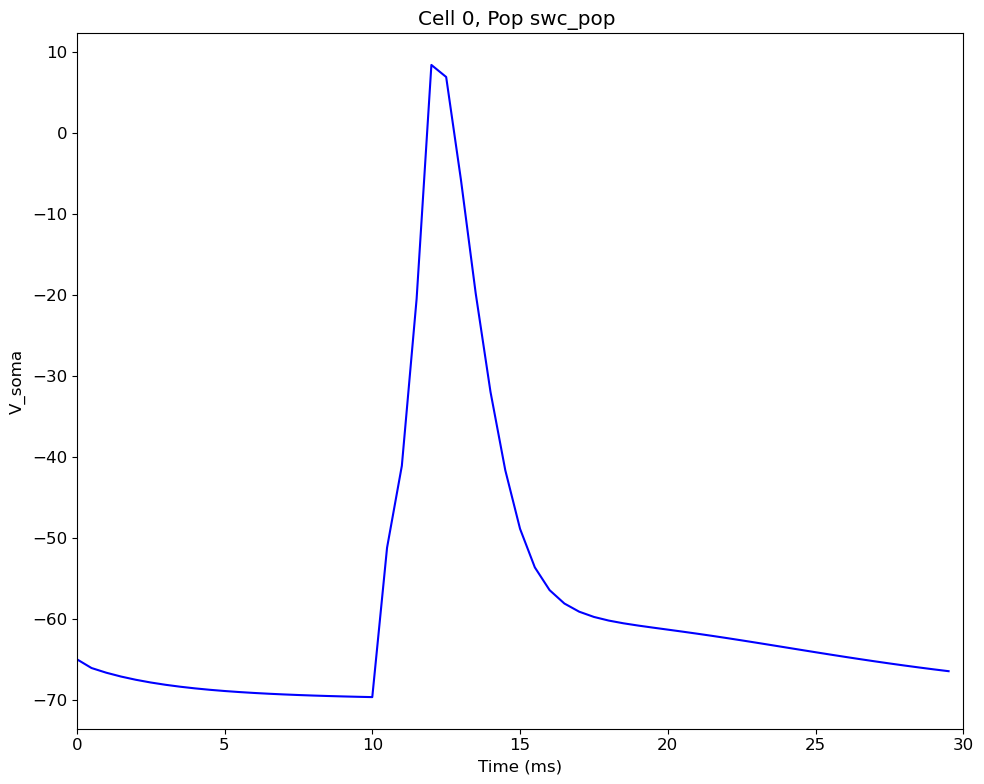

  Done; plotting time = 0.16 s

Total time = 0.26 s


In [14]:
sim.gatherData()
sim.saveData()
sim.analysis.plotData()

Once everything is complete, we'll need to install a couple Python packages to make a movie from our frames.

In [15]:
!python3 -m pip install natsort imageio

Then the following will create an animated gif from the individual figures.

In [16]:
import os
import natsort
import imageio

images = []
filenames = natsort.natsorted(
    [file for file in os.listdir() if "movie" in file and file.endswith(".png")]
)
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave("shape_movie.gif", images)

ValueError: need at least one array to stack

Your movie should show up below:

<img src="shape_movie.gif">